# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

In [2]:
PATH_TO_DATA = Path('/home/tam/data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        idx = self.word2id.get(word, -1)
        if idx==-1:
            return np.zeros(300)
        else:
            vec = self.embeddings[idx]
            return vec
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        vec1 = self.encode(word1)
        vec2 = self.encode(word2)
        cos_sim = np.dot(vec1, vec2)
        cos_sim = cos_sim / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        return cos_sim
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        scores = [self.score(word, self.id2word[i]) for i in range(len(self.words))]
        indexes = list(np.flip(np.argsort(scores)))
        return [self.id2word[i] for i in indexes[:k]]

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'pup', 'canine']
['dogs', 'dog', 'cats', 'puppies', 'Dogs']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg']


In [15]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf = {}
        D = len(sentences)
        for sentence in sentences:
            for word in set(sentence.split(' ')):
                idf[word] = idf.get(word, 0) + 1
                
        for word in idf.keys():
            idf[word] = np.log(D / (idf[word]))

        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        if idf is None:
            words_vec = np.array([word2vec.encode(word) for word in sentence.split(' ')])
            return words_vec.mean(axis=0)
        else:
            # idf-weighted mean of word vectors
            words_vec = np.array([word2vec.encode(word) for word in sentence.split(' ')])
            idf_weights = np.array([idf[word] for word in sentence.split(' ')])
            words_vec = np.average(words_vec, weights=idf_weights, axis=0)
            return words_vec

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        vec1 = self.encode(sentence1, idf)
        vec2 = self.encode(sentence2, idf)
        cos_sim = np.dot(vec1, vec2)
        cos_sim = cos_sim / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        return cos_sim
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        scores = [self.score(sentence, sentence_) for sentence_ in sentences]
        indexes = np.flip(np.argsort(scores))
        return [sentences[i] for i in indexes[:k]]

In [18]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf=None))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence_ in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence_)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence_ in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence_)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251476
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400799939346385
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [19]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        fr_en_words = list(set(self.fr_word2vec.words).intersection(self.en_word2vec.words))
        
        # embedding matrix for french words
        X = np.vstack([fr_word2vec.encode(word) for word in fr_en_words]).T
        # embedding matrix for english words
        Y = np.vstack([en_word2vec.encode(word) for word in fr_en_words]).T
        
        assert X.shape[0] == 300 and Y.shape[0] == 300
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        M = np.dot(Y, X.T)
        u, s, vh = np.linalg.svd(M)
        W = np.dot(u, vh)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        idx = self.fr_word2vec.word2id[fr_word]
        
        # map the french word to the english space
        similarity = self.get_aligned_fr_embeddings()
        fr_vec = similarity[idx]
        
        similarity = self.en_word2vec.embeddings
        # compute the norms
        norm = np.linalg.norm(similarity, axis=1)
        fr_word_norm = np.linalg.norm(fr_vec)
        norm = norm * fr_word_norm
        # then the cosine similarity
        similarity = np.dot(similarity, fr_vec)
        similarity = similarity / norm
        
        indexes = np.flip(np.argsort(similarity))
        return [self.en_word2vec.words[i] for i in indexes[:k]]

In [20]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [21]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# train sentences
train_raw = []
Y_train = []
with open(train_filepath, 'r') as f:
    for line in f:
        Y_train.append(int(line[0]))
        train_raw.append(line[2:])

# dev sentences
dev_raw = []
Y_dev = []
with open(dev_filepath, 'r') as f:
    for line in f:
        Y_dev.append(int(line[0]))
        dev_raw.append(line[2:])

        # test sentences
test_raw = []
with open(test_filepath, 'r') as f:
    for line in f:
        test_raw.append(line)

Loaded 50000 pretrained word vectors


In [10]:
# 2 - Encode sentences with the BoV model above

bov = BagOfWords(word2vec)

idf_train = bov.build_idf(train_raw)
train_idf = np.vstack([bov.encode(s, idf_train) for s in train_raw])
train = np.vstack([bov.encode(s, None) for s in train_raw])

idf_dev = bov.build_idf(dev_raw)
dev_idf = np.vstack([bov.encode(s, idf_dev) for s in dev_raw])
dev =  np.vstack([bov.encode(s, None) for s in dev_raw])

idf_test = bov.build_idf(test_raw)
test_idf = np.vstack([bov.encode(s, idf_test) for s in test_raw])
test = np.vstack([bov.encode(s, None) for s in test_raw])

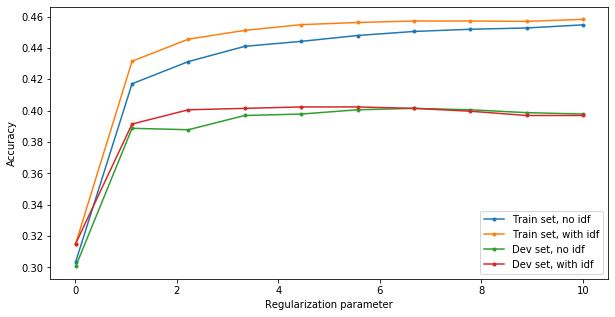

Accuracy on train set for the best parameter: 0.45049157303370785
Accuracy on train set for the best parameter, with idf: 0.45482209737827717
Accuracy on dev set for the best parameter: 0.4014532243415077
Accuracy on dev set for the best parameter, with idf: 0.40236148955495005
Best C no idf:6.67
Best C with idf:4.45


In [12]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 

alpha = np.linspace(10**(-2), 10, 10)

# no idf
acc_train, acc_dev = [], []
for a in alpha:
    clf = LogisticRegression(penalty="l2", C=a, solver='liblinear', multi_class='ovr')
    clf.fit(train, Y_train)
    acc_train.append(clf.score(train, Y_train))
    acc_dev.append(clf.score(dev, Y_dev))

# idf
acc_train_idf, acc_dev_idf = [], []
for a in alpha:
    clf = LogisticRegression(penalty="l2", C=a, solver='liblinear', multi_class='ovr')
    clf.fit(train_idf, Y_train)
    acc_train_idf.append(clf.score(train_idf, Y_train))
    acc_dev_idf.append(clf.score(dev_idf, Y_dev))
    
plt.figure(figsize=(10,5))
plt.plot(alpha, acc_train, '.-', label='Train set, no idf')
plt.plot(alpha, acc_train_idf, '.-', label='Train set, with idf')
plt.plot(alpha, acc_dev, '.-', label='Dev set, no idf')
plt.plot(alpha, acc_dev_idf, '.-', label='Dev set, with idf')
plt.legend(loc='lower right')
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy")
plt.show()

a_best = alpha[np.argmax(acc_dev)]
a_best_idf = alpha[np.argmax(acc_dev_idf)]
clf = LogisticRegression(penalty="l2", C=a_best, solver='liblinear', multi_class='ovr')
clf_idf = LogisticRegression(penalty="l2", C=a_best_idf, solver='liblinear', multi_class='ovr')
clf.fit(train, Y_train)
clf_idf.fit(train_idf, Y_train)
print('Accuracy on train set for the best parameter:', clf.score(train, Y_train))
print('Accuracy on train set for the best parameter, with idf:', clf_idf.score(train_idf, Y_train))
print('Accuracy on dev set for the best parameter:', clf.score(dev, Y_dev))
print('Accuracy on dev set for the best parameter, with idf:', clf_idf.score(dev_idf, Y_dev))
print("Best C no idf:" + str(a_best))
print("Best C with idf:" + str(a_best_idf))

In [13]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
clf = LogisticRegression(penalty="l2", C=a_best_idf, solver='liblinear', multi_class='ovr')
clf.fit(train_idf, Y_train)
Y_pred = clf.predict(test_idf).reshape(-1, 1).astype(int)
np.savetxt("logreg_bov_y_test_sst.txt", Y_pred, '%i') 

In [35]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# Here, I used a SVM classifier on idf vectors

from sklearn.svm import SVC
# the parameters were chosen after some tuning
clf_svm = SVC(C=1, kernel='rbf', gamma='scale')
clf_svm.fit(train_idf, Y_train)
print('Score on dev set:'+str(clf_svm.score(dev_idf, Y_dev)))

Y_pred = clf_svm.predict(test_idf).reshape(-1, 1).astype(int)
np.savetxt("svm_bov_y_test_sst.txt", Y_pred, '%i') 

Score on dev set:0.4123524069028156


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [22]:
import tensorflow as tf

In [23]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# I rather use Tokenizer 
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(train_raw+dev_raw+test_raw)
tokenized = tokenizer.texts_to_sequences(train_raw+dev_raw+test_raw)
train_token = tokenized[:len(train_raw)]
dev_token = tokenized[len(train_raw): len(train_raw)+len(dev_raw)]
test_token = tokenized[len(train_raw)+len(dev_raw): len(train_raw)+len(dev_raw)+len(test_raw)]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [52]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
max_len = 100
from tensorflow.keras.preprocessing import sequence
x_train = sequence.pad_sequences(train_token, maxlen=max_len)
x_dev = sequence.pad_sequences(dev_token, maxlen=max_len)
x_test = sequence.pad_sequences(test_token, maxlen=max_len)


## 4.2 - Design and train your model

In [53]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [54]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          1600000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 1,625,157
Trainable params: 1,625,157
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)

y_train = tf.keras.utils.to_categorical(Y_train)
y_dev = tf.keras.utils.to_categorical(Y_dev)

bs = 64
n_epochs = 6

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_accuracy')

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, 
                    validation_data=(x_dev, y_dev), callbacks=[checkpointer])

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8512/8544 [============================>.] - ETA: 0s - loss: 1.5731 - accuracy: 0.2747
Epoch 00001: val_accuracy improved from -inf to 0.25341, saving model to weights.hdf5
8544/8544 [==============================] - 68s 8ms/sample - loss: 1.5731 - accuracy: 0.2748 - val_loss: 1.5681 - val_accuracy: 0.2534
Epoch 2/6
8512/8544 [============================>.] - ETA: 0s - loss: 1.4938 - accuracy: 0.3311
Epoch 00002: val_accuracy improved from 0.25341 to 0.37965, saving model to weights.hdf5
8544/8544 [==============================] - 53s 6ms/sample - loss: 1.4934 - accuracy: 0.3316 - val_loss: 1.4107 - val_accuracy: 0.3797
Epoch 3/6
8512/8544 [============================>.] - ETA: 0s - loss: 1.2132 - accuracy: 0.4584
Epoch 00003: val_accuracy improved from 0.37965 to 0.39237, saving model to weights.hdf5
8544/8544 [==============================] - 52s 6ms/sample - loss: 1.2135 - accuracy: 0.4577 - val_loss: 1.3590 - val_accura

In [58]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# load best model 
model = tf.keras.models.load_model("weights.hdf5")

Y_pred = np.argmax(model.predict(x_test), axis = 1)
np.savetxt("logreg_lstm_y_test_sst.txt", Y_pred, '%i') 

## 4.3 - innovate !

In [57]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Bidirectional, \
                                    GlobalMaxPooling1D, SpatialDropout1D, Conv1D, GRU, \
                                    GlobalAveragePooling1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


bs = 64
n_epochs = 20
max_words = 50000
embedding_size = 300
max_len = 100

# We use pretrained embeddings
print('- Build embedding_matrix')

word2vec = Word2Vec(en_embeddings_path, vocab_size=max_words)
embedding_matrix = np.empty((max_words, embedding_size,))
embedding_matrix[:] = np.nan

for word in word2vec.words:
    idx = tokenizer.word_index.get(word)
    if (idx != None) and (idx < max_words):
        i = word2vec.word2id[word]
        vector = word2vec.embeddings[i]
        embedding_matrix[idx] = vector

# Fill missing values with normal distribution
print('- Fill nan values with normal distribution')
np.random.seed(42)
emb_not_nan = embedding_matrix[ ~np.isnan(embedding_matrix)]
emb_mean = np.mean(emb_not_nan)
emb_std = np.std(emb_not_nan)

nb_nan = embedding_matrix[ np.isnan(embedding_matrix)].shape[0]
embedding_matrix[ np.isnan(embedding_matrix)] = np.random.normal(emb_mean, emb_std, nb_nan)

# and then, build a model based on a BiLSTM layer concatenate with a Conv1D layer

input_ = Input(shape=(max_len, ))
x = Embedding(max_words, embedding_size, weights=[embedding_matrix],trainable = False)(input_)
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(5, activation="sigmoid")(x)
model = Model(input_, preds)
model.summary()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights_.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_accuracy')

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, 
                    validation_data=(x_dev, y_dev), callbacks=[checkpointer])

model = tf.keras.models.load_model("weights_.hdf5")

Y_pred = np.argmax(model.predict(x_test), axis = 1)
np.savetxt("conv1D_lstm_y_test_sst.txt", Y_pred, '%i') 

- Build embedding_matrix
Loaded 50000 pretrained word vectors
- Fill nan values with normal distribution
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 300)     15000000    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 100, 300)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 100, 128)     186880      spatial_dropout1d_2[0